# iMaterialize competition

[Competition website](https://www.kaggle.com/c/imaterialist-challenge-furniture-2018)

As shoppers move online, it’d be a dream come true to have products in photos classified automatically. But, automatic product recognition is challenging because for the same product, a picture can be taken in different lighting, angles, backgrounds, and levels of occlusion. Meanwhile different fine-grained categories may look very similar, for example, ball chair vs egg chair for furniture, or dutch oven vs french oven for cookware. Many of today’s general-purpose recognition machines simply can’t perceive such subtle differences between photos, yet these differences could be important for shopping decisions.

In this competition, FGVC5 workshop organizers and Malong Technologies challenge you to develop algorithms that will help with an important step towards automatic product recognition – to accurately assign category labels for furniture and home goods images.

## Evaluation

For this competition each image has one ground truth label. An algorithm to be evaluated will produce 1 label per image. If the predicted label is the same as the groundtruth label, then the error for that image is 0, otherwise it is 1. The final score is the error averaged across all images.

## Submission

For each image in the test set, you must predict 1 class label. The csv file should contain a header and have the following format:

|id|label|
|--|:---:|
|12345|0|
|67890|83|
|...|...|

## Data

All the data described below are txt files in JSON format.

**Overview**

train.json: training data with image urls and labels

validation.json: validation data with the same format as train.json

test.json: images of which the participants need to generate predictions. 

**Only image URLs are provided.**

sample_submission_randomlabel.csv: example submission file with random predictions to illustrate the submission file format


The first problem we encounter is that only URLs are provided. That means we have to download all images by ourselves. The exact numbers are:

_"The training dataset includes images from 128 furniture and home goods classes with one ground truth label for each image. It includes a total of 194,828 images for training and 6,400 images for validation and 12,800 images for testing."_

Note: **194,828 images for training and 6,400 images for validation and 12,800 images for testing.**

Wow! That's a huge amount of data!

Because we don't want to download so much training data, we are going to download some images per category and then use data augmentation.

Let's go for it!

## Data examination

Train and validation sets have the same format as shown below:


```json
{

"images" : [image],

"annotations" : [annotation],

}

image{

"image_id" : int,

"url": [string]

}

annotation{

"image_id" : int,

"label_id" : int

}
```


The testing data only has images as shown below:

```json
{

"images" : [image],

}

image {

"image_id" : int,

"url" : [string],

}
```

Let's define the folders we have before we begin.

In [33]:
import json
import os
import requests


DIR_DS = './dataset/'
DIR_TRAIN = DIR_DS + 'train/'
DIR_VAL = DIR_DS + 'validation/'
DIR_TEST = DIR_DS + 'test/'

DIR_OUTPUT = './output/'
DIR_TMP = './tmp/'

FILE_TRAIN = 'train.json'
FILE_VAL = 'validation.json'
FILE_TEST = 'test.json'


MAX_EXAMPLES = 20 # Number of examples for each category

## Parsing and checking the data

Now we are going to take a look at the validation file.

As we've seen above, on one side we have the IDs and the URLs in an array and on the other side we have an array with the annotations for each ID.

In [32]:

data_file = DIR_DS + FILE_TRAIN

data = {}
data = json.load(open(data_file))

# Let's sort them by image_id
data['images'] = sorted(data['images'], key=lambda x: int(x['image_id']))
data['annotations'] = sorted(data['annotations'], key=lambda x: int(x['image_id']))

# Some paranoid checks...
# compare length
assert (len (data['images']) == len (data['annotations']))
# compare first
assert (data['images'][0]['image_id'] == data['annotations'][0]['image_id'])
# compare random
assert (data['images'][123]['image_id'] == data['annotations'][123]['image_id'])

# Let's check the data of the array
print ('Images in total: {}'.format (len (data['images'])))
print ('Annotations in total: {}'.format (len (data['annotations'])))

# Let's check the data for the first element in the arrays
print ('Image id: {}'.format (data['images'][0]['image_id']))
print ('Image url: {}'.format (data['images'][0]['url']))
print ('Image label: {}'.format (data['annotations'][0]['label_id']))

Images in total: 194828
Annotations in total: 194828
Image id: 1
Image url: ['https://img13.360buyimg.com/imgzone/jfs/t2857/351/510705008/279959/4e27dce0/57171f60N523c940e.jpg']
Image label: 5


In [2]:
def loadFile (data_file):
    data = {}
    data = json.load(open(data_file))

    # Let's sort them by image_id
    data['images'] = sorted(data['images'], key=lambda x: int(x['image_id']))
    data['annotations'] = sorted(data['annotations'], key=lambda x: int(x['image_id']))

    return data

## Downloading one image

Now, we are going to download the first image of the validation set.

In [ ]:

test_img_id = data['images'][0]['image_id']
test_img_url = data['images'][0]['url'][0]

try:
    r = requests.get(test_img_url,timeout=5)
    folder_path = DIR_VAL
    with open (folder_path+str(test_img_id)+'.jpg','wb') as f:
        f.write(r.content)
    f.close()

except Exception as e:
    print (str(e))

Display the downloaded image:

Image has shape: (800, 800, 3)


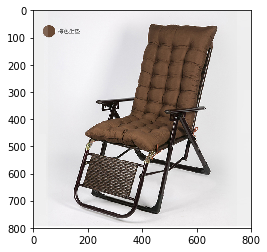

In [10]:
import matplotlib.pyplot as plt

%matplotlib inline

test_img_id = '89864'
label_id = '1'

sample_img_path = os.path.join(DIR_TRAIN,os.path.join(label_id, test_img_id+'.jpg'))
sample_img = plt.imread(sample_img_path)
plt.imshow(sample_img)
print ('Image has shape: {}'.format(sample_img.shape))

Image has shape: (800, 800, 3)
Image has label: 1


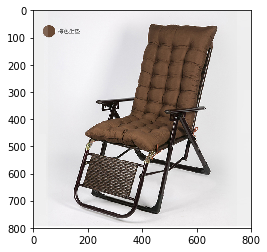

In [17]:
# Using the code of the previous cell, let's build a function to display image's info:

def getLabel (annotations, _id):
    return annotations[_id-1]['label_id']

def displayInfo (folder, annotations, _id, clazz):
    img_path = os.path.join(folder,clazz+'/'+str(_id)+'.jpg')
    img = plt.imread(img_path)
    plt.imshow(img)
    print ('Image has shape: {}'.format(img.shape))
    print ('Image has label: {}'.format(getLabel (annotations, _id)))

displayInfo (DIR_TRAIN, data['annotations'], 89864, '1')

## Downloading the training dataset

194,828 images for training are too much. We are going to dowload 20 of each category and then use data augmentation.

Let's begin with the method for downloading the 'restricted' training dataset.

In [34]:
from tqdm import tqdm

def imageOk (image):
    try:
        sample_img = plt.imread (image)
    
    except Exception as e:
#        print ('Image {} not ok!'.format(image))
        return False

    return True

def downloadAndSaveImage (folder, url, name, timeout=10):
    file = os.path.join(folder,name)
    try:
        if os.path.exists (file) and imageOk (file):
            return True

        r = requests.get(url,timeout=timeout)
        with open (file,'wb') as f:
            f.write(r.content)
        f.close()
        
        if not imageOk (file):
            os.remove (file)

    except Exception as e:
#        print ('Error! name {} : {}'.format (name, e))
        return False
    
    return True

def downloadDataset (folder, images, annotations, examplesPerClassToDownload=MAX_EXAMPLES, timeout=10):
    downloads = {}                  # to keep track about the examples downloaded per category
    for image in tqdm (images):
        img_id = image['image_id']
        filename = str(img_id)+'.jpg'
        label = getLabel (annotations, img_id)
        labelFolder = os.path.join(folder, str(label))
        if not os.path.exists(labelFolder):
            os.makedirs(labelFolder)

        if filename in os.listdir(labelFolder):
            continue
        if label not in downloads:
            if (downloadAndSaveImage (labelFolder, image['url'][0], filename, timeout)):
                downloads[label] = 1
        elif label in downloads and downloads[label] < examplesPerClassToDownload:
            if (downloadAndSaveImage (labelFolder, image['url'][0], filename, timeout)):
                downloads[label] += 1

    print (str(downloads))

In [ ]:
data_val = loadFile (DIR_DS + FILE_VAL)
downloadDataset (DIR_VAL, data_val['images'], data_val['annotations'], examplesPerClass=40, timeout=5)

In [35]:
data_train = loadFile (DIR_DS + FILE_TRAIN)
downloadDataset (DIR_TRAIN, data_train['images'], data_train['annotations'], examplesPerClassToDownload=70, timeout=5)

 81%|████████  | 157747/194828 [4:00:16<13:51:55,  1.35s/it] /anaconda/envs/dl/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:709: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 2. 
  warnings.warn(str(msg))
100%|██████████| 194828/194828 [4:58:30<00:00, 10.88it/s]    

{5: 70, 104: 70, 67: 70, 15: 70, 86: 70, 120: 70, 9: 70, 74: 70, 77: 70, 101: 70, 4: 70, 99: 70, 37: 70, 64: 70, 28: 70, 110: 70, 59: 70, 117: 70, 79: 70, 68: 70, 32: 70, 127: 70, 106: 70, 24: 70, 97: 70, 13: 70, 39: 70, 62: 70, 122: 70, 89: 70, 48: 70, 105: 70, 50: 70, 55: 70, 31: 70, 73: 70, 3: 70, 30: 70, 78: 70, 126: 70, 23: 70, 96: 70, 107: 70, 114: 70, 98: 70, 80: 70, 57: 70, 65: 70, 123: 70, 29: 70, 54: 70, 121: 70, 52: 70, 115: 70, 25: 70, 90: 70, 16: 70, 21: 70, 19: 70, 81: 70, 41: 70, 7: 70, 1: 70, 83: 70, 2: 70, 118: 70, 12: 70, 93: 70, 70: 70, 8: 70, 26: 70, 92: 70, 53: 70, 119: 70, 14: 70, 113: 70, 33: 70, 6: 70, 60: 70, 85: 70, 112: 70, 109: 70, 45: 70, 91: 70, 20: 70, 22: 70, 18: 70, 36: 70, 27: 70, 82: 70, 95: 70, 11: 70, 51: 70, 34: 70, 103: 70, 56: 70, 108: 70, 61: 70, 84: 70, 44: 70, 10: 70, 38: 70, 125: 70, 75: 70, 47: 70, 124: 70, 87: 70, 49: 70, 102: 70, 46: 70, 71: 70, 58: 70, 63: 70, 94: 70, 69: 70, 42: 70, 43: 70, 111: 70, 17: 70, 88: 70, 76: 70, 116: 70, 35: 7

## Building the model


In [ ]:
from keras.applications.xception import Xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K

# create the base pre-trained model
base_model = Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout (0.5)(x)
# one fully connected layer more
x = Dense(512, activation='relu')(x)
x = Dropout (0.5)(x)
# one fully connected layer more
x = Dense(256, activation='relu')(x)
x = Dropout (0.5)(x)
# and a logistic layer --
predictions = Dense(128, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Building the ImageGenerator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = DIR_TRAIN
validation_data_dir = DIR_VAL
nb_train_samples = 8882
nb_validation_samples = 500
epochs = 1
batch_size = 64

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
validation_datagen = ImageDataGenerator (rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size)

#print ('Saving the model...')
#model.save(os.path.join(DIR_TMP,'model.h5'))
#print ('Model saved! Filename: {}'.format (os.path.join(DIR_TMP,'model.h5')))

In [ ]:
def removeInvalidImages (mainfolder):
    folders = os.listdir(mainfolder)
    for folder in folders:
        if not os.path.isdir (os.path.join(mainfolder,folder)): continue
        images = os.listdir(os.path.join(mainfolder,folder))
        for image in images:
            if image == '.DS_Store': continue
            try:
                sample_img = plt.imread(os.path.join(os.path.join(mainfolder, folder), image))

            except Exception as e:
                os.remove (os.path.join(os.path.join(mainfolder, folder), image))
                print ('Image {} removed'.format(image))

In [ ]:
removeInvalidImages (DIR_VAL)

In [ ]:
os.remove('./dataset/train/115/78586.jpg')

In [ ]:
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    np.save(open(os.path.join(DIR_TMP,'bottleneck_features_train.npy'), 'w'), bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
    
    np.save(open(os.path.join(DIR_TMP,'bottleneck_features_train.npy'), 'w'), bottleneck_features_validation)

In [ ]:
def train_top_model():
    train_data = np.load(open(os.path.join(DIR_TMP,'bottleneck_features_train.npy')))
    train_labels = np.array([0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))

    validation_data = np.load(open(os.path.join(DIR_TMP, 'bottleneck_features_validation.npy')))
    validation_labels = np.array([0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(1204, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))

    model.save_weights(top_model_weights_path)
